In [3]:
import os
from time import sleep

import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim
import torch.nn.functional as F
from tqdm import tqdm

from torch.utils.data import DataLoader

!pip install catalyst
from catalyst import dl, utils
from catalyst.contrib import MNIST


     |████████████████████████████████| 536 kB 5.3 MB/s 
     |████████████████████████████████| 120 kB 41.5 MB/s 
     |████████████████████████████████| 596 kB 29.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Data

In [4]:
batch_size = 64

train_data = MNIST(os.getcwd(), train=True)
valid_data = MNIST(os.getcwd(), train=False)
loaders = {
    "train": DataLoader(train_data, batch_size=batch_size),
    "valid": DataLoader(valid_data, batch_size=batch_size),
}

0it [00:00, ?it/s]

Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw


0it [00:00, ?it/s]

Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw


0it [00:00, ?it/s]

Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw


0it [00:00, ?it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw
Processing...


/usr/local/lib/python3.7/dist-packages/catalyst/contrib/datasets/misc.py:188: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


/usr/local/lib/python3.7/dist-packages/catalyst/contrib/datasets/mnist.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(self.data)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


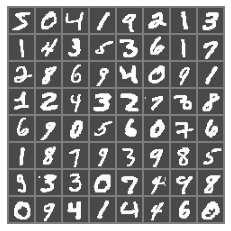

       5        0        4        1        9        2        1        3        1        4        3        5        3        6        1        7        2        8        6        9        4        0        9        1        1        2        4        3        2        7        3        8        6        9        0        5        6        0        7        6        1        8        7        9        3        9        8        5        9        3        3        0        7        4        9        8        0        9        4        1        4        4        6        0


In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()


# get some random training images
dataiter = iter(loaders['train'])
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%8s' % int(labels[j]) for j in range(batch_size)))

## Model

In [6]:
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1)
        self.conv3 = nn.Conv2d(50, 128, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(2 * 2 * 128, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 2 * 2 * 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Trainers

In [7]:
def train_model_torch(Net, loaders, device=torch.device('cpu'), n_epochs=10, verbose=True):
    model = Net().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.02)
    trainloader = loaders['train']
    validloader = loaders['valid']
    
    train_losses = []
    test_losses = []

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        iter = enumerate(trainloader, 0)
        if verbose:
            iter = tqdm(iter)
        for i, data in iter:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
        
        # if verbose or epoch == (n_epochs - 1):
        if verbose:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in validloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(validloader))                    
            print(f"Epoch {epoch+1}/{n_epochs}.. "
                    f"Train loss: {running_loss/len(trainloader):.3f}.. "
                    f"Test loss: {test_loss/len(validloader):.3f}.. "
                    f"Test accuracy: {accuracy/len(validloader):.3f}")
            running_loss = 0.
        
    return model

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [9]:
def train_m_models(Net, M, loaders, device, n_epochs=10):
    models = []
    for i in range(M):
        model = train_model_torch(Net, loaders, device, n_epochs, verbose=False)
        models.append(model)
    return models


## MPI

In [ ]:
!pip install mpi4py
import mpi4py

In [ ]:
%%writefile scripts.py

import os 

import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader

from catalyst.contrib import MNIST


def load_data():
    batch_size = 64

    train_data = MNIST(os.getcwd(), train=True)
    valid_data = MNIST(os.getcwd(), train=False)
    loaders = {
        "train": DataLoader(train_data, batch_size=batch_size),
        "valid": DataLoader(valid_data, batch_size=batch_size),
    }
    return loaders


class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(4 * 4 * 50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



### Independent parallel processes

In [ ]:
%%writefile hppl_project_parallel.py

import os
import pickle
import sys

import numpy as np

import torch
from torch import nn, optim
from tqdm.notebook import tqdm

from mpi4py import MPI

from scripts import load_data, SimpleNet


start = MPI.Wtime()

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

m = size

trainloader = load_data()['train']
model = SimpleNet()

device = 'cpu'
# device = 'cuda'
device = torch.device(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

n_epochs = 2
for i in range(n_epochs):
    for inputs, labels in trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), f"model_{rank}.pth")

end = MPI.Wtime()

if rank == 0:    
    with open(f'timing_par_{size}.pkl', 'wb') as f:
        pickle.dump(end - start, f)


### Several processes (cpu / gpu) - batch broadcasting

In [ ]:
%%writefile hppl_project_batch_bcast.py

import os
import pickle
import sys

import numpy as np

import torch
from torch import nn, optim
from tqdm.notebook import tqdm

from mpi4py import MPI

from scripts import load_data, SimpleNet


start = MPI.Wtime()

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

m = size

if rank == 0:
    trainloader = load_data()['train']
else: 
    trainloader = None

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'
device = torch.device(device)    

model = SimpleNet()
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

n_epochs = 2
n_steps = 938
for i in range(n_epochs):
    if rank == 0:
        iterator = iter(trainloader) 
    for j in range(n_steps):
        if rank == 0:
            inputs, labels = next(iterator)
        else:
            inputs = labels = None
        inputs = comm.bcast(inputs, root=0).to(device)
        labels = comm.bcast(labels, root=0).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

torch.save(model.state_dict(), f"model_{rank}.pth")

end = MPI.Wtime()

if rank == 0:    
    with open(f'timing_bcast_{size}.pkl', 'wb') as f:
        pickle.dump(end - start, f)


### 2 CPU + 1 GPU - Batch Broadcasting

In [ ]:
%%writefile hppl_project_cpu_gpu.py

import os
import pickle
import sys

import numpy as np

import torch
from torch import nn, optim
from tqdm.notebook import tqdm

from mpi4py import MPI

from scripts import load_data, SimpleNet


start = MPI.Wtime()

comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

m = size

if rank == 0:
    trainloader = load_data()['train']
else: 
    trainloader = None

if rank == 2 and size > 2:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    
else:
    device = torch.device('cpu')

model = SimpleNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

n_epochs = 2
n_steps = 938
for i in range(n_epochs):
    if rank == 0:
        iterator = iter(trainloader) 
    for j in range(n_steps):
        if rank == 0:
            inputs, labels = next(iterator)
        else:
            inputs = labels = None
        inputs = comm.bcast(inputs, root=0).to(device)
        labels = comm.bcast(labels, root=0).to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    

torch.save(model.state_dict(), f"model_{rank}.pth")

end = MPI.Wtime()

if rank == 0:    
    with open(f'timing_cpugpu_{size}.pkl', 'wb') as f:
        pickle.dump(end - start, f)


In [ ]:
n_processes = 2
!mpirun --allow-run-as-root -n {n_processes} python3 hppl_project_parallel.py

In [ ]:
n_processes = 2
!mpirun --allow-run-as-root -n {n_processes} python3 hppl_project_batch_bcast.py

In [ ]:
n_processes = 3
!mpirun --allow-run-as-root -n {n_processes} python3 hppl_project_cpu_gpu.py

In [ ]:
import pickle
with open(f'timing_bcast_{2}.pkl', 'rb') as f:
    time_spent_mpi = pickle.load(f)
time_spent_mpi

## Consequent training 

In [34]:
def load_data():
    batch_size = 64

    train_data = MNIST(os.getcwd(), train=True)
    valid_data = MNIST(os.getcwd(), train=False)
    loaders = {
        "train": DataLoader(train_data, batch_size=batch_size),
        "valid": DataLoader(valid_data, batch_size=batch_size),
    }
    return loaders


def train_m_models(Net, M, loaders=None, device=torch.device('cpu'), n_epochs=10):
    if loaders is None:
        loaders = load_data()
    models = []
    for i in range(M):
        model = train_model_torch(Net, loaders, device, n_epochs, verbose=False)
        models.append(model)
    return models


In [ ]:
%%time

train_m_models(SimpleNet, 2, None, device, 2)

## Results

Parallel with broadcasting batches:

2 CPU + 1 GPU: 241.0 seconds (3 models, 2 epochs)

2 CPU: 157.7 seconds (2 models, 2 epochs)

2 GPU: 24.0 seconds (2 models, 2 epochs)

\

Parallel with independent data:

2 CPU + 1 GPU: 181.4 seconds (3 models, 2 epochs)

2 CPU: 167.0 seconds (2 models, 2 epochs)

2 GPU: 25.5 seconds (2 models, 2 epochs)

\

Loop with consequent training:

CPU: 206 seconds (2 model, 2 epochs) (232 with verbose)

GPU: 37.6 seconds (2 model, 2 epochs) (45.1 with verbose)